# Consider filtering out clear vs deg trials with the below, and looking for differences.
### First look doesn't correspond to my intuition, but subspaces were computed on mixed trials.
## To determine if dynamics are really different in the presence of degredation (i.e. the need for priors and therefore more FBC activity), I should re-run the deg paradigm but only on clear face trials. Compute subspaces. See if it looks like the dynamics in the clear faces stimuli.

In [11]:
import pdb
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pickle
import pandas as pd
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

sys.path.append('/home/marcush/projects/neural_control/')
sys.path.append('/home/marcush/projects/neural_control/analysis_scripts/')
sys.path.append('/home/marcush/projects/github_repos')
sys.path.append('/home/marcush/projects/neural_control/notebooks/TsaoLabNotebooks/CodeAndFigsForPaper')
from dca.methods_comparison import JPCA 

from utils import apply_df_filters


from utils import apply_df_filters, calc_loadings
from region_select import *


# Load Data Structures

In [12]:
dimreduc_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output_new/dimreduc_deg_230322_214006_Jamie/dimreduc_deg_230322_214006_Jamie_glom.pickle'
with open(dimreduc_glom_path, 'rb') as f:
    dat = pickle.load(f) 
df_dimreduc = pd.DataFrame(dat)

paradigm_session_name = os.path.splitext(os.path.basename(dimreduc_glom_path))[0]

In [13]:
def make_hashable(obj):
    if isinstance(obj, dict):
        return tuple(sorted((key, make_hashable(value)) for key, value in obj.items()))
    elif isinstance(obj, (list, tuple)):
        return tuple(make_hashable(item) for item in obj)
    else:
        return obj


unique_hashes = set(make_hashable(d) for d in df_dimreduc['full_arg_tuple'])
unique_dicts = [dict(u) for u in unique_hashes]
preload_dict_path = df_dimreduc['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)

In [14]:
for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)
                    AM_data_file = loaded_data_path


            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)
                    ML_data_file = loaded_data_path


AM_spikes = AM_loaded_data['spike_rates']
ML_spikes = ML_loaded_data['spike_rates']

## Plots and Analyses for Region AM

In [15]:
calcs = True
rot_trajectories = True
run_dyn_range = True
boxplots = True

In [16]:
curr_Region = 'AM'
DIM = 21
jDIM = DIM - 1 # must be even for jPCA 
LD_args = {'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'region': curr_Region, 'degraded': True}
data_files = [df_dimreduc['data_file'][0]]
dpath = AM_data_file

### Generate random projections used to for later comparison

In [17]:
inner_reps = 5 #1000
random_proj_path = f'./jPCA_structs/jpca_{curr_Region}_randomcontrol_{paradigm_session_name}.dat'

if not os.path.exists(random_proj_path):
    resultsd3 = []
    for i, data_file in tqdm(enumerate(data_files)):
       
        dat = AM_loaded_data
        y = np.squeeze(dat['spike_rates'])

        for j in tqdm(range(inner_reps)):
            V = scipy.stats.special_ortho_group.rvs(y.shape[-1], random_state=np.random.RandomState(j))
            V = V[:, 0:DIM]
            # Project data
            yproj = y @ V

            # Segment reaches into minimum length 30 timesteps reaches
            #yproj = np.array([yproj[t0:t0+20] for t0, t1 in dat['transition_times'] if t1 - t0 > 21])
            # yproj = gaussian_filter1d(yproj, sigma=5)

            result_ = {}
            result_['data_file'] = data_file
            result_['inner_rep'] = j

            jpca = JPCA(n_components=jDIM, mean_subtract=False)
            jpca.fit(yproj)
            
            # ypred = yproj[:-1, :] @ jpca.M_skew
            #r2_linear = linmodel.score(yproj[:-1, :], np.diff(yproj, axis=0))
            result_['jeig'] = jpca.eigen_vals_

            yprojcent = np.array([y_ - y_[0:1, :] for y_ in yproj])
            dyn_range = np.array([np.max(np.abs(y_)[:, j]) for y_ in yprojcent for j in range(jDIM)])
            result_['dyn_range'] = np.mean(dyn_range)
            resultsd3.append(result_)


            print(f"Done with jPCA fit {j+1} of {inner_reps}.")

    with open(random_proj_path, 'wb') as f:
        f.write(pickle.dumps(resultsd3))            

print('Loading Existing Random Control')

Loading Existing Random Control


## Begin jPCA Projections

In [21]:
save_path_projs = f'./jPCA_structs/jpca_{curr_Region}_projs_{paradigm_session_name}.dat'

if calcs:
    resultsd3 = []

    data_file = AM_data_file
    dat = AM_loaded_data

    for i, data_file in tqdm(enumerate(data_files)):

        y = np.squeeze(dat['spike_rates'])
        for dimreduc_method in ['LQGCA', 'PCA']:
            df_ = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method=dimreduc_method, loader_args=LD_args)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={})

            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        

            # Project data
            yproj = y @ V
            #yproj = np.array([yproj[t0:t0+20] for t0, t1 in dat['transition_times'] if t1 - t0 > 21])

            result_ = {}
            result_['data_file'] = data_file
            result_['dimreduc_method'] = dimreduc_method


            # 3 fits: Look at symmetric vs. asymmetric portions of regression onto differences
            jpca = JPCA(n_components=jDIM, mean_subtract=False)
            jpca.fit(yproj)
            
            result_['jeig'] = jpca.eigen_vals_
            yprojcent = yproj

            print('%s\n' % dimreduc_method)

            dyn_range = np.array([np.max(np.abs(y_)[:, j]) for y_ in yprojcent for j in range(jDIM)])
            result_['dyn_range'] = np.mean(dyn_range)

            resultsd3.append(result_)

        with open(save_path_projs, 'wb') as f:
            f.write(pickle.dumps(resultsd3))            
else:
    with open(save_path_projs, 'rb') as f:
        resultsd3 = pickle.load(f)

A_df = pd.DataFrame(resultsd3)

d_U = np.zeros((len(data_files), 2, 3))
maxim = np.zeros((len(data_files), 2, 3))

random_proj_path = f'./jPCA_structs/jpca_{curr_Region}_randomcontrol_{paradigm_session_name}.dat'
with open(random_proj_path, 'rb') as f:
    control_results = pickle.load(f)
controldf = pd.DataFrame(control_results)

control_reps = len(controldf['inner_rep'])

maxim_control = np.zeros((len(data_files), control_reps, 3))

for i in range(len(data_files)):
    for j, dimreduc_method in enumerate(['LQGCA', 'PCA']):
        df_ = apply_df_filters(A_df, data_file=data_files[i], dimreduc_method=dimreduc_method)
        
        eigs = df_.iloc[0]['jeig']

        maxim[i, j, 0] = np.sum(np.abs(eigs))/2

        maxim[i, j, 1] = np.sum(np.abs(eigs))/2
        maxim[i, j, 2] = df_.iloc[0]['dyn_range']

    for j in range(maxim_control.shape[1]):
        df_ = apply_df_filters(controldf, data_file=data_files[i], inner_rep=j)
        assert(df_.shape[0] == 1)

        eigs = df_.iloc[0]['jeig']
        maxim_control[i, j, 0] = np.sum(np.abs(eigs))/2
        maxim_control[i, j, 1] = np.sum(np.abs(eigs))/2
        eigs = df_.iloc[0]['dyn_range']
        maxim_control[i, j, 2] = eigs


0it [00:00, ?it/s]

LQGCA

PCA



1it [00:23, 23.71s/it]


Re p:0.500000


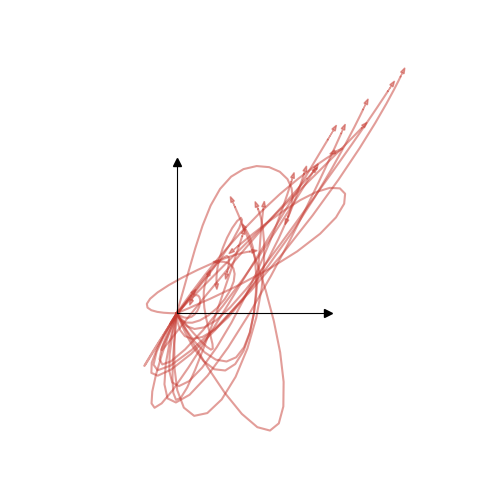

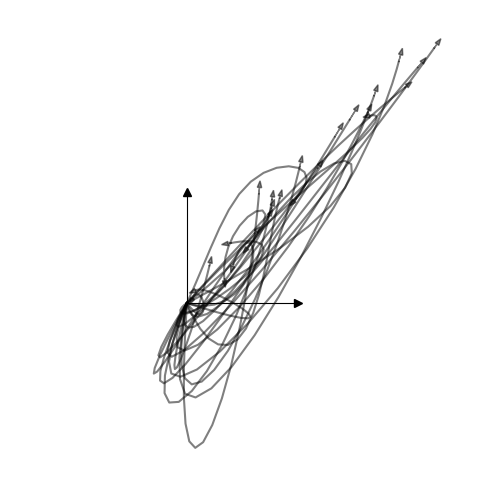

In [11]:
if rot_trajectories:

    data_file = data_files[0]
    
    dat = AM_loaded_data
    df1 = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method='PCA', loader_args=LD_args)
    df2 = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method='LQGCA', loader_args=LD_args)


    x = dat['spike_rates']
    xpca = x @ df1.iloc[0]['coef'][:, 0:jDIM]
    xdca = x @ df2.iloc[0]['coef']

    jpca1 = JPCA(n_components=jDIM, mean_subtract=False)
    jpca1.fit(xpca)

    jpca2 = JPCA(n_components=jDIM, mean_subtract=False)
    jpca2.fit(xdca)

    xpca_j = jpca1.transform(xpca)
    xdca_j = jpca2.transform(xdca)

    xpca_j_mean = np.mean(xpca_j, 0).squeeze()
    xdca_j_mean = np.mean(xdca_j, 0).squeeze()



    ################################### PLOT CODE ##############################

    # Save as two separate figures
    fig1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 5))
    ax = [ax1, ax2]

    for i in range(0, 25):
        
        """" 
        idx = dca_devorder[i]
        t0 = transition_times[idx][0]
        t1 = min(transition_times[idx][0] + 40, transition_times[idx][1])
        trajectory = gaussian_filter1d(xpca_j[0, t0:t1],  sigma=5, axis=0)[:-3]
        """
        trajectory = gaussian_filter1d(xpca_j[i,:,:].squeeze(),  sigma=4, axis=0)

        # Center and normalize trajectories
        trajectory -= trajectory[0]
        #trajectory /= np.linalg.norm(trajectory)

        # Rotate trajectory so that the first 5 timesteps all go off at the same angle
        theta0 = np.arctan2(trajectory[15, 1], trajectory[15, 0])

        # Rotate *clockwise* by theta
        R = lambda theta: np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                                    [np.sin(-theta), np.cos(theta)]])        
        trajectory = np.array([R(theta0 - np.pi/4) @ t[0:2] for t in trajectory])

        ax[1].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.5)
        ax[1].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                    trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                    head_width=0.08, color="k", alpha=0.5)
        
        """" 
        idx = dca_devorder[i]
        t0 = transition_times[idx][0]
        t1 = min(transition_times[idx][0] + 40, transition_times[idx][1])
        trajectory = gaussian_filter1d(xdca_j[0, t0:t1], sigma=5, axis=0)[:-3]
        """
        trajectory = gaussian_filter1d(xdca_j[i,:,:].squeeze(),  sigma=4, axis=0)

        # Center trajectories
        trajectory -= trajectory[0]
        #trajectory /= np.linalg.norm(trajectory)

        # Rotate trajectory so that the first 5 timesteps all go off at the same angle
        theta0 = np.arctan2(trajectory[15, 1], trajectory[15, 0])

        trajectory = np.array([R(theta0 - np.pi/4) @ t[0:2] for t in trajectory])

        ax[0].plot(trajectory[:, 0], trajectory[:, 1], '#c73d34', alpha=0.5)
        ax[0].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                    trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                    head_width=0.05, color="#c73d34", alpha=0.5)

    _, p = scipy.stats.wilcoxon(maxim[:, 0, 2], maxim[:, 1, 2], alternative='less')
    print('Re p:%f' % p)


    ax[0].set_aspect('equal')   
    ax[1].set_aspect('equal')
    ax[1].set_xlim([-3.2, 5.3])
    ax[1].set_ylim([-3.2, 5.3])

    ax[0].set_xlim([-2.2, 4])
    ax[0].set_ylim([-2.2, 4])


    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')
    ax[0].spines['left'].set_position('zero')
    ax[0].spines['bottom'].set_position('zero')
    ax[0].plot(2, 0, ">k", clip_on=False)
    ax[0].plot(0, 2, "^k", clip_on=False)
    ax[0].spines['left'].set_bounds(0, 2)
    ax[0].spines['bottom'].set_bounds(0, 2)

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')
    ax[1].spines['left'].set_position('zero')
    ax[1].spines['bottom'].set_position('zero')
    ax[1].spines['left'].set_bounds(0, 2)
    ax[1].spines['bottom'].set_bounds(0, 2)
    ax[1].plot(2, 0, ">k", clip_on=False)
    ax[1].plot(0, 2, "^k", clip_on=False)

    fig1.tight_layout()
    #fig1.savefig('%s/trajectories_a.pdf' % figpath, bbox_inches='tight', pad_inches=0)

    fig2.tight_layout()
    #fig2.savefig('%s/trajectories_b.pdf' % figpath, bbox_inches='tight', pad_inches=0)


# Next Plots: Trajectory Amplification 

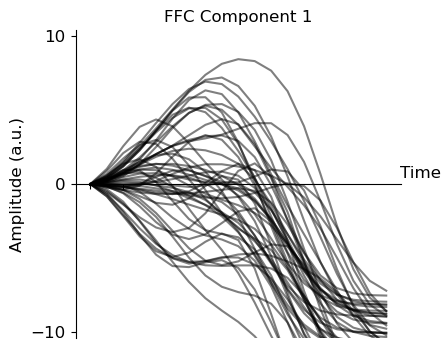

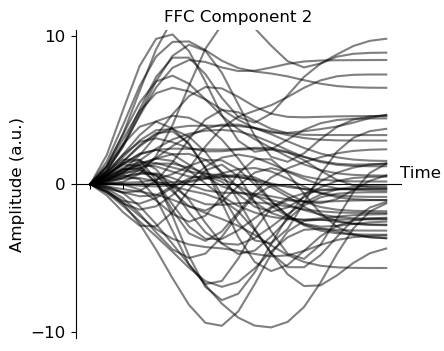

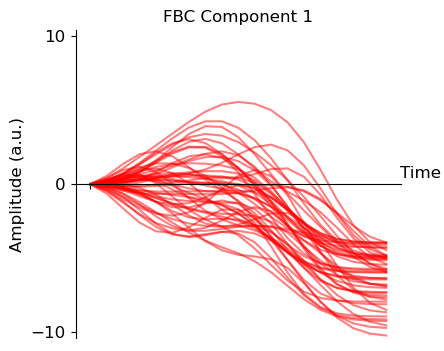

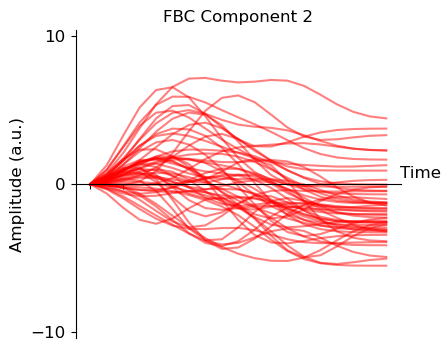

In [12]:
############## Trajectory Amplification #################
if run_dyn_range:

    dat = AM_loaded_data
    y = np.squeeze(dat['spike_rates'])

    colors = ['k', 'r']
    for j, dimreduc_method in enumerate(['PCA', 'LQGCA']):
        df_ = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method=dimreduc_method, loader_args=LD_args)

        #if dimreduc_method == 'LQGCA':
        #    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})

        assert(df_.shape[0] == 1)
        V = df_.iloc[0]['coef']
        if dimreduc_method == 'PCA':
            V = V[:, 0:DIM]        

        # Project data
        yproj = y @ V
        #yproj = np.array([yproj[t0:t0+40] for t0, t1 in dat['transition_times'] if t1 - t0 > 40])
        yproj = np.array([y_ - y_[0] for y_ in yproj])
        dY = np.concatenate(np.diff(yproj, axis=1), axis=0)
        Y_prestate = np.concatenate(yproj[:, :-1], axis=0)

        # Least squares
        A, _, _, _ = np.linalg.lstsq(Y_prestate, dY, rcond=None)
        _, s, _ = np.linalg.svd(A)
        #print('%s' % dimreduc_method + s)

        # Identify the directions in which there is the most amplification over multiple timesteps
        # Project the data along those directions and also record the amplification implied by the model
    
        # Iterate the lyapunov equation for 10 timesteps
        P = np.zeros((DIM, DIM))
        for _ in range(10):
            dP = A @ P + P @ A.T + np.eye(DIM)
            P += dP

        eig, U = np.linalg.eig(P)
        # eig, U = np.linalg.eig(scipy.linalg.expm(A.T) @ scipy.linalg.expm(A))
        eig = np.sort(eig)[::-1]
        U = U[:, np.argsort(eig)[::-1]]
        U = U[:, 0:2]
        # Plot smoothed, centered trajectories for all reaches in top 2 dimensions

        # Argsort by the maximum amplitude in the top 2 dimensions
        #trajectory = gaussian_filter1d(yproj, sigma=5, axis=1)
        trajectory = gaussian_filter1d(yproj, sigma=2, axis=1)

        trajectory -= trajectory[:, 0:1, :]
        trajectory = trajectory @ U
        dyn_range = np.max(np.abs(trajectory), axis=1)
        #dyn_range = np.max(np.abs(yproj @ U), axis=1)
        ordering = np.argsort(dyn_range, axis=0)[::-1]

        #t0 = trajectory[ordering[:, 0], :, 0]
        #t1 = trajectory[ordering[:, 1], :, 1]
        t0 = trajectory[:, :, 0]
        t1 = trajectory[:, :, 1]

        f1, a1 = plt.subplots(1, 1, figsize=(4.2, 4))
        f2, a2 = plt.subplots(1, 1, figsize=(4.2, 4))
        ax = [a1, a2]

        for i in range(min(50, t0.shape[0])):
            ax[0].plot(np.arange(len(t0[i])), t0[i], color=colors[j], alpha=0.5, linewidth=1.5)
            ax[1].plot(np.arange(len(t1[i])), t1[i], color=colors[j], alpha=0.5, linewidth=1.5)
            #ax[2*j].set_title(np.sum(eig))
            
        for a in ax:
            a.spines['bottom'].set_position('center')
            # Eliminate upper and right axes
            a.spines['right'].set_color('none')
            a.spines['top'].set_color('none')

            # Show ticks in the left and lower axes only
            a.xaxis.set_ticks_position('bottom')
            a.yaxis.set_ticks_position('left')

            a.set_xticks([0, 2])
            a.set_xticklabels([])
            a.tick_params(axis='both', labelsize=12)

            a.set_xlabel('Time (s)', fontsize=12)
            a.xaxis.set_label_coords(1.1, 0.56)
            
        # Set y scale according to the current yscale on PCA 0
        if j == 0:
            ylim_max = np.max(np.abs(t0[0])) + 1.5
            ylim = [-ylim_max, ylim_max]

        for a in ax:
            a.set_ylim(ylim)
            a.set_yticks([-int(ylim_max), 0, int(ylim_max)])
            a.set_ylabel('Amplitude (a.u.)', fontsize=12)

        if j == 0:
            ax[0].set_title('FFC Component 1', fontsize=12)
            ax[1].set_title('FFC Component 2', fontsize=12)
        else:
            ax[0].set_title('FBC Component 1', fontsize=12)
            ax[1].set_title('FBC Component 2', fontsize=12)

        #f1.tight_layout()
        #f2.tight_layout()
        #f1.savefig('/home/akumar/nse/neural_control/figs/amplification/%d_e_%s1.pdf' % (didx, dimreduc_method), bbox_inches='tight', pad_inches=0)
        #f2.savefig('/home/akumar/nse/neural_control/figs/amplification/%d_e_%s2.pdf' % (didx, dimreduc_method), bbox_inches='tight', pad_inches=0)


# Boxplots !

Im p:0.500000
0.5
0.5


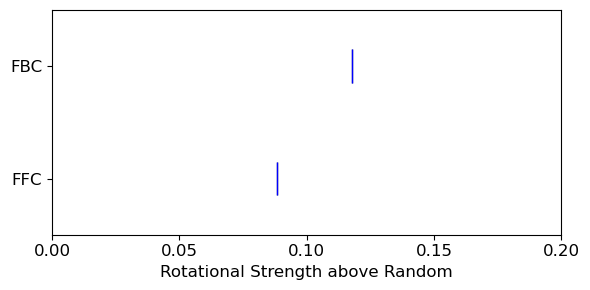

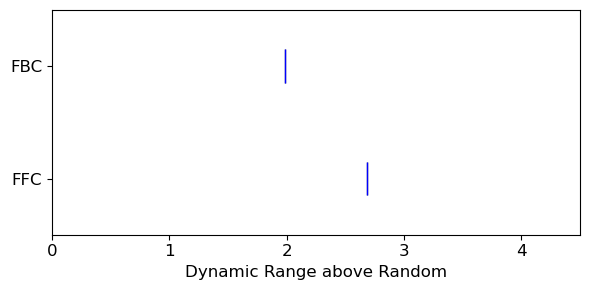

In [24]:
if boxplots:
    # Boxplots
    fig0, ax0 = plt.subplots(figsize=(6, 3))

    medianprops = dict(linewidth=1, color='b')
    whiskerprops=dict(linewidth=0)

    # Center relative to random - per recording session
    mu = np.mean(maxim_control[..., 1], axis=1)
    sigma = np.std(maxim_control[..., 1], axis=1)
    r1 = maxim[:, 0, 1] - mu
    r2 = maxim[:, 1, 1] - mu

    bplot = ax0.boxplot([r1, r2], patch_artist=True, 
                    medianprops=medianprops, notch=False, vert=False, showfliers=False, widths=[0.3, 0.3],
                    whiskerprops=whiskerprops, showcaps=False)
    
    

    _, p = scipy.stats.wilcoxon(maxim[:, 0, 1], maxim[:, 1, 1], alternative='greater')
    print('Im p:%f' % p)

    # test that each is stochastically greater than the median random
    x1 = maxim[:, 0, 1] - np.median(maxim_control[..., 1].ravel())
    x2 = maxim[:, 1, 1] - np.median(maxim_control[..., 1].ravel())

    _, p1 = scipy.stats.wilcoxon(x1, alternative='greater')
    _, p2 = scipy.stats.wilcoxon(x2, alternative='greater')


    method1 = 'FBC'
    method2 = 'FFC'

    ax0.set_yticklabels([method1, method2], fontsize=12)
    ax0.set_xticks([0, 0.05, 0.1, 0.15, 0.2])
    ax0.set_xlim([0, 0.2])
    ax0.tick_params(axis='both', labelsize=12)
    #ax.set_ylabel(r'$\sum_i Im(\lambda_i)$', fontsize=22)
    ax0.set_xlabel('Rotational Strength above Random', fontsize=12)
    #ax.set_title('****', fontsize=14)

    ax0.invert_yaxis()

    fig0.tight_layout()

    fig1, ax1 = plt.subplots(figsize=(6, 3))

    # fill with colors
    colors = ['red', 'black', 'blue']   
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    whiskerprops = dict(linewidth=0)

    mu = np.mean(maxim_control[..., 2], axis=1)
    sigma = np.std(maxim_control[..., 2], axis=1)
    r1 = maxim[:, 0, 2] - mu
    r2 = maxim[:, 1, 2] - mu

    bplot = ax1.boxplot([r1, r2], patch_artist=True, 
                    medianprops=medianprops, notch=False, vert=False, showfliers=False, widths=[0.3, 0.3],
                    whiskerprops=whiskerprops, showcaps=False)

    x1 = maxim[:, 0, 2] - np.median(maxim_control[..., 2].ravel())
    x2 = maxim[:, 1, 2] - np.median(maxim_control[..., 2].ravel())

    _, p1 = scipy.stats.wilcoxon(x1, alternative='greater')
    _, p2 = scipy.stats.wilcoxon(x2, alternative='greater')
    print(p1)
    print(p2)

    method1 = 'FBC'
    method2 = 'FFC'

    ax1.set_yticklabels([method1, method2], fontsize=12)
    ax1.set_xticks([0, 1, 2, 3, 4])
    ax1.set_xlim([0, 4.5])
    ax1.tick_params(axis='both', labelsize=12)
    #ax.set_ylabel(r'$\sum_i Im(\lambda_i)$', fontsize=22)
    ax1.set_xlabel('Dynamic Range above Random', fontsize=12)
    #ax.set_title('****', fontsize=14)

    ax1.invert_yaxis()

    # fill with colors
    colors = ['red', 'black', 'blue']   
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)


    # ax.set_xlim([13, 0])

    fig1.tight_layout()
    #fig.savefig('%s/jpca_eig_bplot_wcontrol2.pdf' % figpath, pad_inches=1)

## Plots and Analyses for Region ML

In [14]:
calcs = True
rot_trajectories = True
run_dyn_range = True
boxplots = True

In [15]:
curr_Region = 'ML'
DIM = 21
jDIM = DIM - 1 # must be even for jPCA 
LD_args = {'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'region': curr_Region, 'degraded': True}
data_files = [df_dimreduc['data_file'][0]]
dpath = ML_data_file

### Generate random projections used to for later comparison

In [16]:
inner_reps = 5 #1000
random_proj_path = f'./jPCA_structs/jpca_{curr_Region}_randomcontrol_{paradigm_session_name}.dat'

if not os.path.exists(random_proj_path):
    resultsd3 = []
    for i, data_file in tqdm(enumerate(data_files)):
       
        dat = ML_loaded_data
        y = np.squeeze(dat['spike_rates'])

        for j in tqdm(range(inner_reps)):
            V = scipy.stats.special_ortho_group.rvs(y.shape[-1], random_state=np.random.RandomState(j))
            V = V[:, 0:DIM]
            # Project data
            yproj = y @ V

            # Segment reaches into minimum length 30 timesteps reaches
            #yproj = np.array([yproj[t0:t0+20] for t0, t1 in dat['transition_times'] if t1 - t0 > 21])
            # yproj = gaussian_filter1d(yproj, sigma=5)

            result_ = {}
            result_['data_file'] = data_file
            result_['inner_rep'] = j

            jpca = JPCA(n_components=jDIM, mean_subtract=False)
            jpca.fit(yproj)
            
            # ypred = yproj[:-1, :] @ jpca.M_skew
            #r2_linear = linmodel.score(yproj[:-1, :], np.diff(yproj, axis=0))
            result_['jeig'] = jpca.eigen_vals_

            yprojcent = np.array([y_ - y_[0:1, :] for y_ in yproj])
            dyn_range = np.array([np.max(np.abs(y_)[:, j]) for y_ in yprojcent for j in range(jDIM)])
            result_['dyn_range'] = np.mean(dyn_range)
            resultsd3.append(result_)


            print(f"Done with jPCA fit {j+1} of {inner_reps}.")

    with open(random_proj_path, 'wb') as f:
        f.write(pickle.dumps(resultsd3))            

print('Loading Existing Random Control')

0it [00:00, ?it/s]

Done with jPCA fit 1 of 5.


Done with jPCA fit 2 of 5.


Done with jPCA fit 3 of 5.


Done with jPCA fit 4 of 5.


100%|██████████| 5/5 [00:25<00:00,  5.04s/it]
1it [00:25, 25.22s/it]

Done with jPCA fit 5 of 5.
Loading Existing Random Control


## Begin jPCA Projections

In [17]:
save_path_projs = f'./jPCA_structs/jpca_{curr_Region}_projs_{paradigm_session_name}.dat'

if calcs:
    resultsd3 = []

    data_file = ML_data_file
    dat = ML_loaded_data

    for i, data_file in tqdm(enumerate(data_files)):

        y = np.squeeze(dat['spike_rates'])
        for dimreduc_method in ['LQGCA', 'PCA']:
            df_ = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method=dimreduc_method, loader_args=LD_args)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={})

            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        

            # Project data
            yproj = y @ V
            #yproj = np.array([yproj[t0:t0+20] for t0, t1 in dat['transition_times'] if t1 - t0 > 21])

            result_ = {}
            result_['data_file'] = data_file
            result_['dimreduc_method'] = dimreduc_method


            # 3 fits: Look at symmetric vs. asymmetric portions of regression onto differences
            jpca = JPCA(n_components=jDIM, mean_subtract=False)
            jpca.fit(yproj)
            
            result_['jeig'] = jpca.eigen_vals_
            yprojcent = yproj

            print('%s\n' % dimreduc_method)

            dyn_range = np.array([np.max(np.abs(y_)[:, j]) for y_ in yprojcent for j in range(jDIM)])
            result_['dyn_range'] = np.mean(dyn_range)

            resultsd3.append(result_)

        with open(save_path_projs, 'wb') as f:
            f.write(pickle.dumps(resultsd3))            
else:
    with open(save_path_projs, 'rb') as f:
        resultsd3 = pickle.load(f)

A_df = pd.DataFrame(resultsd3)

d_U = np.zeros((len(data_files), 2, 3))
maxim = np.zeros((len(data_files), 2, 3))

random_proj_path = f'./jPCA_structs/jpca_{curr_Region}_randomcontrol_{paradigm_session_name}.dat'
with open(random_proj_path, 'rb') as f:
    control_results = pickle.load(f)
controldf = pd.DataFrame(control_results)

control_reps = len(controldf['inner_rep'])

maxim_control = np.zeros((len(data_files), control_reps, 3))

for i in range(len(data_files)):
    for j, dimreduc_method in enumerate(['LQGCA', 'PCA']):
        df_ = apply_df_filters(A_df, data_file=data_files[i], dimreduc_method=dimreduc_method)
        
        eigs = df_.iloc[0]['jeig']

        maxim[i, j, 0] = np.sum(np.abs(eigs))/2

        maxim[i, j, 1] = np.sum(np.abs(eigs))/2
        maxim[i, j, 2] = df_.iloc[0]['dyn_range']

    for j in range(maxim_control.shape[1]):
        df_ = apply_df_filters(controldf, data_file=data_files[i], inner_rep=j)
        assert(df_.shape[0] == 1)

        eigs = df_.iloc[0]['jeig']
        maxim_control[i, j, 0] = np.sum(np.abs(eigs))/2
        maxim_control[i, j, 1] = np.sum(np.abs(eigs))/2
        eigs = df_.iloc[0]['dyn_range']
        maxim_control[i, j, 2] = eigs


0it [00:00, ?it/s]

LQGCA



1it [00:09,  9.70s/it]

PCA



Re p:0.500000


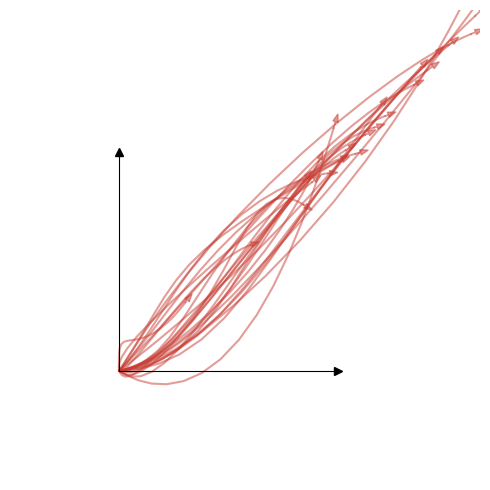

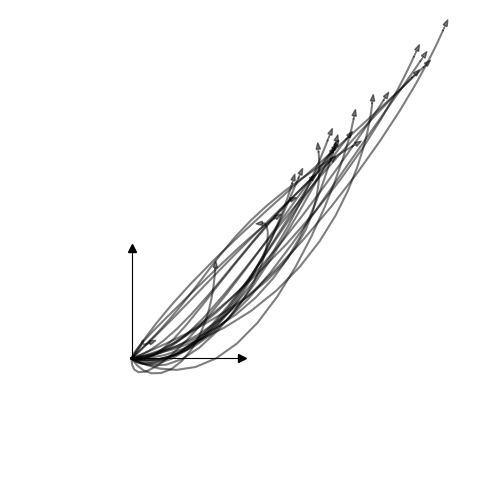

In [18]:
if rot_trajectories:

    data_file = data_files[0]
    
    dat = ML_loaded_data
    df1 = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method='PCA', loader_args=LD_args)
    df2 = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method='LQGCA', loader_args=LD_args)


    x = dat['spike_rates']
    xpca = x @ df1.iloc[0]['coef'][:, 0:jDIM]
    xdca = x @ df2.iloc[0]['coef']

    jpca1 = JPCA(n_components=jDIM, mean_subtract=False)
    jpca1.fit(xpca)

    jpca2 = JPCA(n_components=jDIM, mean_subtract=False)
    jpca2.fit(xdca)

    xpca_j = jpca1.transform(xpca)
    xdca_j = jpca2.transform(xdca)

    xpca_j_mean = np.mean(xpca_j, 0).squeeze()
    xdca_j_mean = np.mean(xdca_j, 0).squeeze()



    ################################### PLOT CODE ##############################

    # Save as two separate figures
    fig1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 5))
    ax = [ax1, ax2]

    for i in range(0, 25):
        
        """" 
        idx = dca_devorder[i]
        t0 = transition_times[idx][0]
        t1 = min(transition_times[idx][0] + 40, transition_times[idx][1])
        trajectory = gaussian_filter1d(xpca_j[0, t0:t1],  sigma=5, axis=0)[:-3]
        """
        trajectory = gaussian_filter1d(xpca_j[i,:,:].squeeze(),  sigma=4, axis=0)

        # Center and normalize trajectories
        trajectory -= trajectory[0]
        #trajectory /= np.linalg.norm(trajectory)

        # Rotate trajectory so that the first 5 timesteps all go off at the same angle
        theta0 = np.arctan2(trajectory[15, 1], trajectory[15, 0])

        # Rotate *clockwise* by theta
        R = lambda theta: np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                                    [np.sin(-theta), np.cos(theta)]])        
        trajectory = np.array([R(theta0 - np.pi/4) @ t[0:2] for t in trajectory])

        ax[1].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.5)
        ax[1].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                    trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                    head_width=0.08, color="k", alpha=0.5)
        
        """" 
        idx = dca_devorder[i]
        t0 = transition_times[idx][0]
        t1 = min(transition_times[idx][0] + 40, transition_times[idx][1])
        trajectory = gaussian_filter1d(xdca_j[0, t0:t1], sigma=5, axis=0)[:-3]
        """
        trajectory = gaussian_filter1d(xdca_j[i,:,:].squeeze(),  sigma=4, axis=0)

        # Center trajectories
        trajectory -= trajectory[0]
        #trajectory /= np.linalg.norm(trajectory)

        # Rotate trajectory so that the first 5 timesteps all go off at the same angle
        theta0 = np.arctan2(trajectory[15, 1], trajectory[15, 0])

        trajectory = np.array([R(theta0 - np.pi/4) @ t[0:2] for t in trajectory])

        ax[0].plot(trajectory[:, 0], trajectory[:, 1], '#c73d34', alpha=0.5)
        ax[0].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                    trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                    head_width=0.05, color="#c73d34", alpha=0.5)

    _, p = scipy.stats.wilcoxon(maxim[:, 0, 2], maxim[:, 1, 2], alternative='less')
    print('Re p:%f' % p)


    ax[0].set_aspect('equal')   
    ax[1].set_aspect('equal')
    ax[1].set_xlim([-2.2, 6.3])
    ax[1].set_ylim([-2.2, 6.3])

    ax[0].set_xlim([-1, 3.3])
    ax[0].set_ylim([-1, 3.3])


    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')
    ax[0].spines['left'].set_position('zero')
    ax[0].spines['bottom'].set_position('zero')
    ax[0].plot(2, 0, ">k", clip_on=False)
    ax[0].plot(0, 2, "^k", clip_on=False)
    ax[0].spines['left'].set_bounds(0, 2)
    ax[0].spines['bottom'].set_bounds(0, 2)

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')
    ax[1].spines['left'].set_position('zero')
    ax[1].spines['bottom'].set_position('zero')
    ax[1].spines['left'].set_bounds(0, 2)
    ax[1].spines['bottom'].set_bounds(0, 2)
    ax[1].plot(2, 0, ">k", clip_on=False)
    ax[1].plot(0, 2, "^k", clip_on=False)

    fig1.tight_layout()
    #fig1.savefig('%s/trajectories_a.pdf' % figpath, bbox_inches='tight', pad_inches=0)

    fig2.tight_layout()
    #fig2.savefig('%s/trajectories_b.pdf' % figpath, bbox_inches='tight', pad_inches=0)


# Next Plots: Trajectory Amplification 

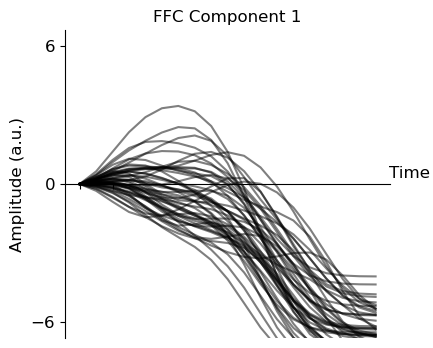

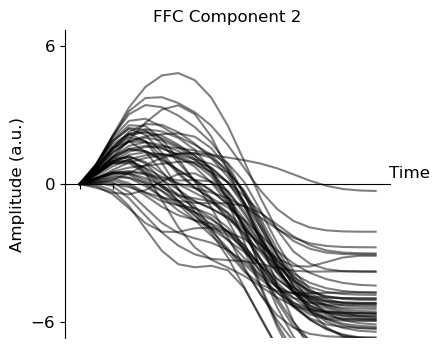

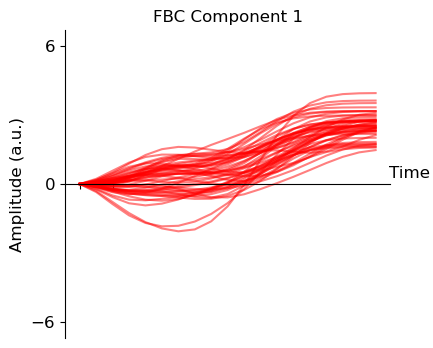

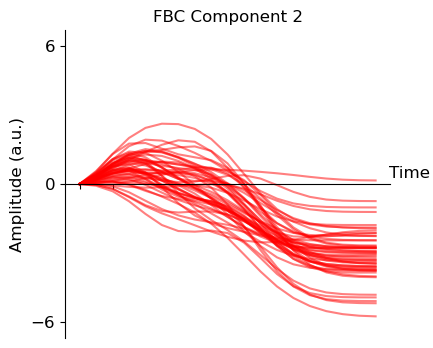

In [22]:
############## Trajectory Amplification #################
if run_dyn_range:

    dat = ML_loaded_data
    y = np.squeeze(dat['spike_rates'])

    colors = ['k', 'r']
    for j, dimreduc_method in enumerate(['PCA', 'LQGCA']):
        df_ = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method=dimreduc_method, loader_args=LD_args)

        #if dimreduc_method == 'LQGCA':
        #    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})

        assert(df_.shape[0] == 1)
        V = df_.iloc[0]['coef']
        if dimreduc_method == 'PCA':
            V = V[:, 0:DIM]        

        # Project data
        yproj = y @ V
        #yproj = np.array([yproj[t0:t0+40] for t0, t1 in dat['transition_times'] if t1 - t0 > 40])
        yproj = np.array([y_ - y_[0] for y_ in yproj])
        dY = np.concatenate(np.diff(yproj, axis=1), axis=0)
        Y_prestate = np.concatenate(yproj[:, :-1], axis=0)

        # Least squares
        A, _, _, _ = np.linalg.lstsq(Y_prestate, dY, rcond=None)
        _, s, _ = np.linalg.svd(A)
        #print('%s' % dimreduc_method + s)

        # Identify the directions in which there is the most amplification over multiple timesteps
        # Project the data along those directions and also record the amplification implied by the model
    
        # Iterate the lyapunov equation for 10 timesteps
        P = np.zeros((DIM, DIM))
        for _ in range(10):
            dP = A @ P + P @ A.T + np.eye(DIM)
            P += dP

        eig, U = np.linalg.eig(P)
        # eig, U = np.linalg.eig(scipy.linalg.expm(A.T) @ scipy.linalg.expm(A))
        eig = np.sort(eig)[::-1]
        U = U[:, np.argsort(eig)[::-1]]
        U = U[:, 0:2]
        # Plot smoothed, centered trajectories for all reaches in top 2 dimensions

        # Argsort by the maximum amplitude in the top 2 dimensions
        #trajectory = gaussian_filter1d(yproj, sigma=5, axis=1)
        trajectory = gaussian_filter1d(yproj, sigma=2, axis=1)

        trajectory -= trajectory[:, 0:1, :]
        trajectory = trajectory @ U
        dyn_range = np.max(np.abs(trajectory), axis=1)
        #dyn_range = np.max(np.abs(yproj @ U), axis=1)
        ordering = np.argsort(dyn_range, axis=0)[::-1]

        #t0 = trajectory[ordering[:, 0], :, 0]
        #t1 = trajectory[ordering[:, 1], :, 1]
        t0 = trajectory[:, :, 0]
        t1 = trajectory[:, :, 1]

        f1, a1 = plt.subplots(1, 1, figsize=(4.2, 4))
        f2, a2 = plt.subplots(1, 1, figsize=(4.2, 4))
        ax = [a1, a2]

        for i in range(min(50, t0.shape[0])):
            ax[0].plot(np.arange(len(t0[i])), t0[i], color=colors[j], alpha=0.5, linewidth=1.5)
            ax[1].plot(np.arange(len(t1[i])), t1[i], color=colors[j], alpha=0.5, linewidth=1.5)
            #ax[2*j].set_title(np.sum(eig))
            
        for a in ax:
            a.spines['bottom'].set_position('center')
            # Eliminate upper and right axes
            a.spines['right'].set_color('none')
            a.spines['top'].set_color('none')

            # Show ticks in the left and lower axes only
            a.xaxis.set_ticks_position('bottom')
            a.yaxis.set_ticks_position('left')

            a.set_xticks([0, 2])
            a.set_xticklabels([])
            a.tick_params(axis='both', labelsize=12)

            a.set_xlabel('Time (s)', fontsize=12)
            a.xaxis.set_label_coords(1.1, 0.56)
            
        # Set y scale according to the current yscale on PCA 0
        if j == 0:
            ylim_max = np.max(np.abs(t0[0])) + 0.25
            ylim = [-ylim_max, ylim_max]

        for a in ax:
            a.set_ylim(ylim)
            a.set_yticks([-int(ylim_max), 0, int(ylim_max)])
            a.set_ylabel('Amplitude (a.u.)', fontsize=12)

        if j == 0:
            ax[0].set_title('FFC Component 1', fontsize=12)
            ax[1].set_title('FFC Component 2', fontsize=12)
        else:
            ax[0].set_title('FBC Component 1', fontsize=12)
            ax[1].set_title('FBC Component 2', fontsize=12)

        #f1.tight_layout()
        #f2.tight_layout()
        #f1.savefig('/home/akumar/nse/neural_control/figs/amplification/%d_e_%s1.pdf' % (didx, dimreduc_method), bbox_inches='tight', pad_inches=0)
        #f2.savefig('/home/akumar/nse/neural_control/figs/amplification/%d_e_%s2.pdf' % (didx, dimreduc_method), bbox_inches='tight', pad_inches=0)


Im p:1.000000
0.5
0.5


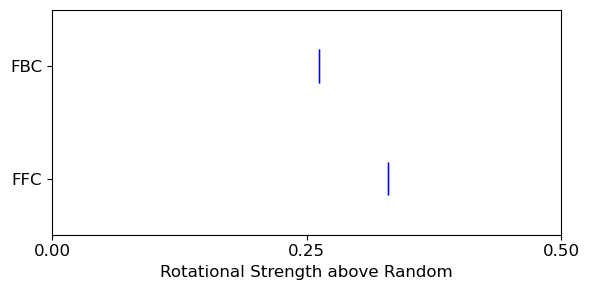

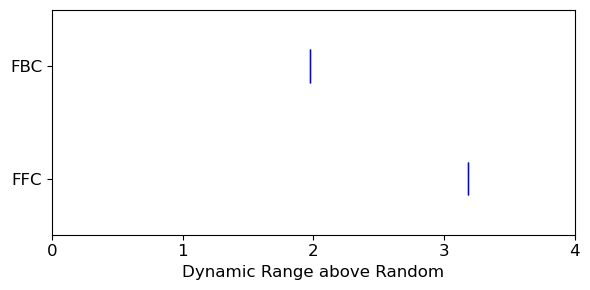

In [26]:
if boxplots:
    # Boxplots
    #fig, ax = plt.subplots(2, 1, figsize=(6, 3))
    fig0, ax0 = plt.subplots(figsize=(6, 3))

    medianprops = dict(linewidth=1, color='b')
    whiskerprops=dict(linewidth=0)
    #bplot = ax.boxplot([d_U[:, 2, 1], d_U[:, 3, 1]], patch_artist=True, medianprops=medianprops, notch=True, vert=False, showfliers=False)
    # Plot relative to the control...test for difference from zero

    # Center relative to random - per recording session
    mu = np.mean(maxim_control[..., 1], axis=1)
    sigma = np.std(maxim_control[..., 1], axis=1)
    r1 = maxim[:, 0, 1] - mu
    r2 = maxim[:, 1, 1] - mu

    bplot = ax0.boxplot([r1, r2], patch_artist=True, 
                    medianprops=medianprops, notch=False, vert=False, showfliers=False, widths=[0.3, 0.3],
                    whiskerprops=whiskerprops, showcaps=False)
    
    

    # _, p = scipy.stats.wilcoxon(d_U[:, 2, 1], d_U[:, 3, 1])
    _, p = scipy.stats.wilcoxon(maxim[:, 0, 1], maxim[:, 1, 1], alternative='greater')
    print('Im p:%f' % p)

    # test that each is stochastically greater than the median random
    x1 = maxim[:, 0, 1] - np.median(maxim_control[..., 1].ravel())
    x2 = maxim[:, 1, 1] - np.median(maxim_control[..., 1].ravel())

    _, p1 = scipy.stats.wilcoxon(x1, alternative='greater')
    _, p2 = scipy.stats.wilcoxon(x2, alternative='greater')

    # _, p = scipy.stats.wilcoxon(maxim[:, 0, 2], maxim[:, 1, 2], alternative='less')
    # print('Re p:%f' % p)

    # Mutliple comparison adjusted test of maxim control against PCA and FCCA
    # _, p1 = scipy.stats.mannwhitneyu(maxim[:, 0, 1], maxim_control[..., 1].ravel(), alternative='greater')
    # _, p2 = scipy.stats.mannwhitneyu(maxim[:, 1, 1], maxim_control[..., 1].ravel(), alternative='greater')

    # print((p1, p2))

    method1 = 'FBC'
    method2 = 'FFC'

    ax0.set_yticklabels([method1, method2], fontsize=12)
    ax0.set_xticks([0, 0.25, 0.5])
    ax0.set_xlim([0, 0.5])
    ax0.tick_params(axis='both', labelsize=12)
    #ax.set_ylabel(r'$\sum_i Im(\lambda_i)$', fontsize=22)
    ax0.set_xlabel('Rotational Strength above Random', fontsize=12)
    #ax.set_title('****', fontsize=14)

    ax0.invert_yaxis()

    fig0.tight_layout()
    fig0.show()

    fig1, ax1 = plt.subplots(figsize=(6, 3))

    # fill with colors
    colors = ['red', 'black', 'blue']   
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    whiskerprops = dict(linewidth=0)

    mu = np.mean(maxim_control[..., 2], axis=1)
    sigma = np.std(maxim_control[..., 2], axis=1)
    r1 = maxim[:, 0, 2] - mu
    r2 = maxim[:, 1, 2] - mu

    bplot = ax1.boxplot([r1, r2], patch_artist=True, 
                    medianprops=medianprops, notch=False, vert=False, showfliers=False, widths=[0.3, 0.3],
                    whiskerprops=whiskerprops, showcaps=False)

    x1 = maxim[:, 0, 2] - np.median(maxim_control[..., 2].ravel())
    x2 = maxim[:, 1, 2] - np.median(maxim_control[..., 2].ravel())

    _, p1 = scipy.stats.wilcoxon(x1, alternative='greater')
    _, p2 = scipy.stats.wilcoxon(x2, alternative='greater')
    print(p1)
    print(p2)

    method1 = 'FBC'
    method2 = 'FFC'

    ax1.set_yticklabels([method1, method2], fontsize=12)
    ax1.set_xticks([0, 1, 2, 3, 4])
    ax1.set_xlim([0, 4])
    ax1.tick_params(axis='both', labelsize=12)
    #ax.set_ylabel(r'$\sum_i Im(\lambda_i)$', fontsize=22)
    ax1.set_xlabel('Dynamic Range above Random', fontsize=12)
    #ax.set_title('****', fontsize=14)

    ax1.invert_yaxis()

    # fill with colors
    colors = ['red', 'black', 'blue']   
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)


    # ax.set_xlim([13, 0])

    fig1.tight_layout()
    fig1.show()
    #fig.savefig('%s/jpca_eig_bplot_wcontrol2.pdf' % figpath, pad_inches=1)